In [1]:
# 
# Copyright (c) 2023 Go2Market Insights d/b/a Analyzr
# All rights reserved
# https://analyzr.ai
# 
# The above copyright notice and this permission notice shall be included in all copies or substantial portions
# of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO
# THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
# TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
# 
# For Python SDK reference go to https://https://analyzr-sdk-python.readthedocs.io/
# For support go to https://support.analyzr.ai
# 
# To run this notebook you will need the following Python packages:
#   - pandas
#   - numpy
#   - analyzrclient
#   - matplotlib
#   - seaborn
#
# This notebook was automatically generated by Analyzr.
#
import pandas as pd
import numpy as np
import sys, os, uuid
from copy import deepcopy
import datetime 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

In [2]:
# 
# LOAD DATA
# 
# This notebook assumes your original source file is in the same folder as this Jupyter
# notebook. You may need to update the path below. 
# 
raw_data = pd.read_csv('https://g2mstaticfiles.blob.core.windows.net/$web/public_datasets/mmm.csv', encoding = "ISO-8859-1", low_memory=False)
raw_data.head()

,Date,TV,Radio,Banners,Sales
0,2018-01-07,13528.1,0.00,0.00,9779.80
1,2018-01-14,0.0,5349.65,2218.93,13245.19
2,2018-01-21,0.0,4235.86,2046.96,12022.66
3,2018-01-28,0.0,3562.21,0.00,8846.95
4,2018-02-04,0.0,0.00,2187.29,9797.07


In [3]:
# 
# TAKE A SUBSET OF THE ORIGINAL DATASET
# 
# This step selects a subset of the original dataset for training purposes. 
# It also assigns a record identifier field (ID_FIELD) for audit and reconciliation 
# purposes. 
# 
SELECTED_FIELDS = [
    'Date',
    'TV',
    'Radio',
    'Banners',
    'Sales',
]
ID_FIELD = 'Date'
df = raw_data[SELECTED_FIELDS].dropna()
df[ID_FIELD] = df[ID_FIELD].astype('string')
df.head()

,Date,TV,Radio,Banners,Sales
0,2018-01-07,13528.1,0.00,0.00,9779.80
1,2018-01-14,0.0,5349.65,2218.93,13245.19
2,2018-01-21,0.0,4235.86,2046.96,12022.66
3,2018-01-28,0.0,3562.21,0.00,8846.95
4,2018-02-04,0.0,0.00,2187.29,9797.07


In [4]:
# 
# ASSIGN VARIABLE TYPES
# 
# This step assigns variable types. OUTCOME_VAR identifies the dependent variable.
# Other arrays identify independent variables by type: categorical, numerical, or boolean. 
# 
OUTCOME_VAR = 'Sales' 
CATEGORICAL_VARS = [] 
NUMERICAL_VARS = ['TV', 'Radio', 'Banners', 'Sales'] 
BOOLEAN_VARS = [] 
LAGGING_VARS = ['TV', 'Radio', 'Banners']
SATURATION_VARS = ['TV', 'Radio', 'Banners']

In [5]:
# 
# START ANALYZR CLIENT
# 
# Access to the Analyzr API requires credentials. Contact your account manager or contact 
# our support team at https://support.analyzr.ai for more info. If you are a free tier user 
# you can skip this step altogether and use your local compute resources. 
# 
# For installation instructions on the Analyzr client see https://github.com/analyzr-ai/analyzr-sdk-python
# 
from analyzrclient import Analyzer
analyzer = Analyzer(host='analyzr3.api.g2m.ai')
analyzer.login()
analyzer.version()

Login successful


{'api': {'status': 200, 'version': 'v1.7.24', 'tenant': 'Analyzr3'},
 'client': {'version': '1.3.17'},
 'copyright': '2023 (c) Go2Market Insights Inc. All rights reserved. Patent pending. '}

In [6]:
#
# TRAIN MODEL
#
# This step performs model training and cross-validation. If you do not have API access, e.g. free 
# tier users, you will need to replace the training command with your own model.fit() statement 
# for model training and cross-validation using local compute resources.  
# 
# Note also this version keeps polling the API while the model is training. For longer training runs 
# you may want to disable polling and manually check the status of your model (see next cell). 
# 
t_0 = datetime.datetime.now()
client_id = 'test'
algorithm = 'linear-regression'
verbose = True
res = analyzer.regression.train(
    df, client_id=client_id, 
    idx_var=ID_FIELD, outcome_var=OUTCOME_VAR, categorical_vars=CATEGORICAL_VARS, numerical_vars=NUMERICAL_VARS, 
    saturation_vars=SATURATION_VARS, lagging_vars=LAGGING_VARS, algorithm=algorithm, train_size=1.0, 
    buffer_batch_size=1000, verbose=verbose, poll=True, compressed=True, encoding=False
)
print('model_id: {}'.format(res['model_id']))
print('total time: {}'.format(datetime.datetime.now()-t_0))

Model ID: cc8ed0e6-b86c-46c5-b2af-db45992df365
Saving data to buffer...
        Processed batch 1 of 1
Training regression model using data in buffer...
Training request posted.
[_poll][80] {'status': 200, 'response': {'request_id': 'cc8ed0e6-b86c-46c5-b2af-db45992df365', 'status': 'Complete', 'details': 'Post-processing results in analytics engine...'}}
Retrieving training results...
    Retrieving features...
    Retrieving performance stats...
    Retrieving coefficients...
    Retrieving saturation and lagging parameters...
Clearing buffer...
model_id: cc8ed0e6-b86c-46c5-b2af-db45992df365
total time: 0:01:52.836316


In [7]:
#
# CHECK STATUS OF MODEL RUN
# 
# For manual polling uncomment the lines below. 
# 
# res = analyzer.regression.check_status(model_id=res['model_id'], client_id=client_id, verbose=True) 
# res 

<Axes: xlabel='Importance', ylabel='Feature'>

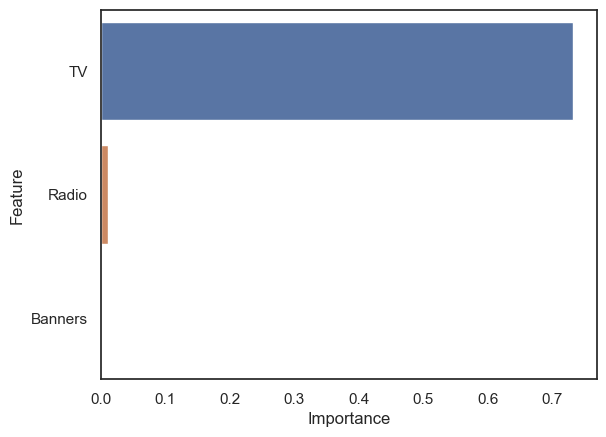

In [8]:
#
# DISPLAY FEATURE IMPORTANCE 
#
sns.barplot(data=res['features'][0:15], x='Importance', y='Feature')

In [9]:
#
# SHOW FEATURE IMPORTANCE TABLE
#
res['features']

,Feature,Importance
0,TV,0.733065
1,Radio,0.011266
2,Banners,0.001419


In [10]:
#
# SHOW ERROR STATISTICS
#
res['stats']

,Parameter,Value
0,R2,0.721348
1,r2,0.941998
2,RMSE,648.801038
3,MSE,420942.786815
4,MAE,525.006513
5,MAPE,0.051951


In [11]:
#
# SHOW COEFFICIENTS WHEN APPLICABLE
#
res['coefs']

,Parameter,SE,Value,p,t
0,TV,0.009820982198817184,10225.651246,0.0,1041204.5393422068
1,Radio,0.01870519524888512,2402.663074,0.0,128448.97055210038
2,Banners,0.05365341768873504,2453.736864,0.0,45733.09529942748


In [12]:
res['laggingsats']

,Parameter,Transformer Type,Value,Variable
0,length,carryover,0.000000,Banners
1,strength,carryover,0.875143,Banners
2,a,saturation,0.006595,Banners
3,length,carryover,0.000000,Radio
4,strength,carryover,0.478265,Radio
5,a,saturation,0.005531,Radio
6,length,carryover,4.000000,TV
7,strength,carryover,0.446595,TV
8,a,saturation,0.000055,TV


In [14]:
res = analyzer.regression.predict(
    df, client_id=client_id, 
    idx_var=ID_FIELD, categorical_vars=CATEGORICAL_VARS, numerical_vars=NUMERICAL_VARS, 
    saturation_vars=SATURATION_VARS, lagging_vars=LAGGING_VARS,  
    buffer_batch_size=1000, verbose=verbose, poll=True, compressed=True, encoding=False
)

TypeError: predict() got an unexpected keyword argument 'saturation_vars'